#Reading Data

In [1]:
#import libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#reading the data

df = pd.read_csv('/content/drive/MyDrive/all_anonymized_2015_11_2017_03.csv')

print(f'Rows are : {df.shape[0]} and Columns are : {df.shape[1]}\n')
df.head()

Rows are : 3552912 and Columns are : 16



,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,NaN,man,5.0,7.0,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,NaN,man,5.0,5.0,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,NaN,man,5.0,5.0,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,NaN,man,5.0,5.0,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,NaN,man,5.0,5.0,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [3]:
# df.info()
# print('\n')
# df.describe()

#Data-preprocessing

In [4]:
# 1.Checking for unique values in the dataset

for col in df.columns:
  print(f"Number of unique values in '{col}' are: {df[col].nunique()}")


# 2.Checking for duplicate values in the dataset

print(df.duplicated().sum())
df = df.drop_duplicates()


#Checking for null values in the dataset

round((df.isnull().sum()/df.shape[0]) * 100,2).sort_values(ascending=False)

# 3.Removing unwanted columns

df_1 = df.drop(['color_slug','stk_year','date_created', 'date_last_seen'], axis=1)
# df_1.columns

Number of unique values in 'maker' are: 46
Number of unique values in 'model' are: 1012
Number of unique values in 'mileage' are: 248142
Number of unique values in 'manufacture_year' are: 1640
Number of unique values in 'engine_displacement' are: 7272
Number of unique values in 'engine_power' are: 641
Number of unique values in 'body_type' are: 9
Number of unique values in 'color_slug' are: 14
Number of unique values in 'stk_year' are: 231
Number of unique values in 'transmission' are: 2
Number of unique values in 'door_count' are: 18
Number of unique values in 'seat_count' are: 57
Number of unique values in 'fuel_type' are: 5
Number of unique values in 'date_created' are: 3552912
Number of unique values in 'date_last_seen' are: 3355057
Number of unique values in 'price_eur' are: 227305
0


In [5]:
# 4.Handling missing values

num_cols = df_1.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df_1[col].fillna(df_1[col].median(), inplace=True)

cat_cols = df_1.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_1[col].fillna(df_1[col].mode()[0], inplace=True)

# 5.Remove the outliers

def remove_outliers(df):
  numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

  for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
  return df

df_1_noutliers = remove_outliers(df_1)
df_1_noutliers.shape

(2452540, 12)

In [6]:
# 6.Format the data type

df_1_noutliers['manufacture_year'] = df_1_noutliers['manufacture_year'].astype('int64')
df_1_noutliers['door_count'] = df_1_noutliers['door_count'].astype('int64')
df_1_noutliers['seat_count'] = df_1_noutliers['seat_count'].astype('int64')

# 7.normalization

scaler = MinMaxScaler()

# Fit and transform the data
df_1_noutliers[['mileage','engine_displacement','engine_power','price_eur']] = scaler.fit_transform(df_1_noutliers[['mileage','engine_displacement','engine_power','price_eur']])


# 8.Categorical to numeric

body_type_mapping = {'van': 0, 'compact': 1, 'transporter': 2, 'coupe': 3, 'convertible' : 4, 'sedan':5, 'stationwagon':6, 'offroad':7,'other': 8}
transmission_mapping = {'man': 0, 'auto': 1}
fuel_type_mapping = {'diesel':0, 'gasoline':1, 'lpg':2, 'cng':3, 'electric':4}

df_1_noutliers['body_type_numeric'] = df_1_noutliers['body_type'].map(body_type_mapping)
df_1_noutliers['transmission_numeric'] = df_1_noutliers['transmission'].map(transmission_mapping)
df_1_noutliers['fuel_type_numeric'] = df_1_noutliers['fuel_type'].map(fuel_type_mapping)

# 9.Changing the column names as to effectively identify the target variable and use the existing column for future feature creation.

df_1_noutliers.rename(columns={'price_eur': 'car_price'}, inplace=True)


df_model = df_1_noutliers.drop(['maker','model','body_type','transmission', 'fuel_type'], axis=1)

#Data

In [ ]:
df_1_noutliers.head(1)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,fuel_type,car_price,body_type_numeric,transmission_numeric,fuel_type_numeric
1,skoda,octavia,0.422983,2012,0.635719,0.434783,other,man,5,5,diesel,0.248278,8,0,0


#EDA

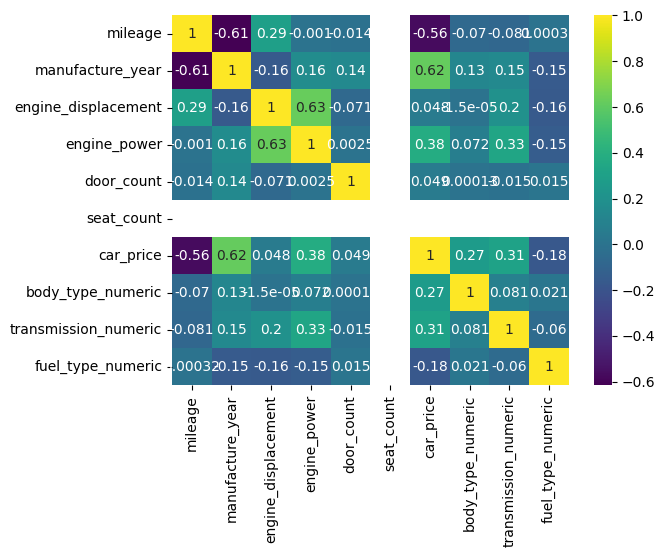

In [ ]:
# EDA-1

corr = df_1_noutliers[['mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'door_count', 'seat_count', 'car_price', 'body_type_numeric', 'transmission_numeric', 'fuel_type_numeric']].corr()
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()

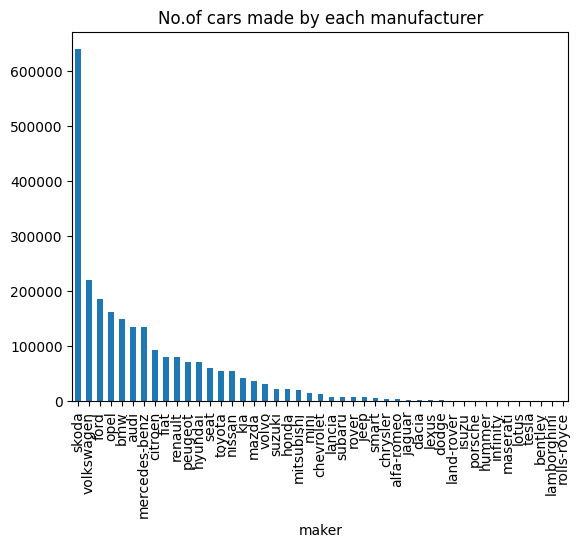

In [ ]:
# EDA-2

df_1_noutliers['maker'].value_counts().plot(kind='bar')
plt.title('No.of cars made by each manufacturer')
plt.show()

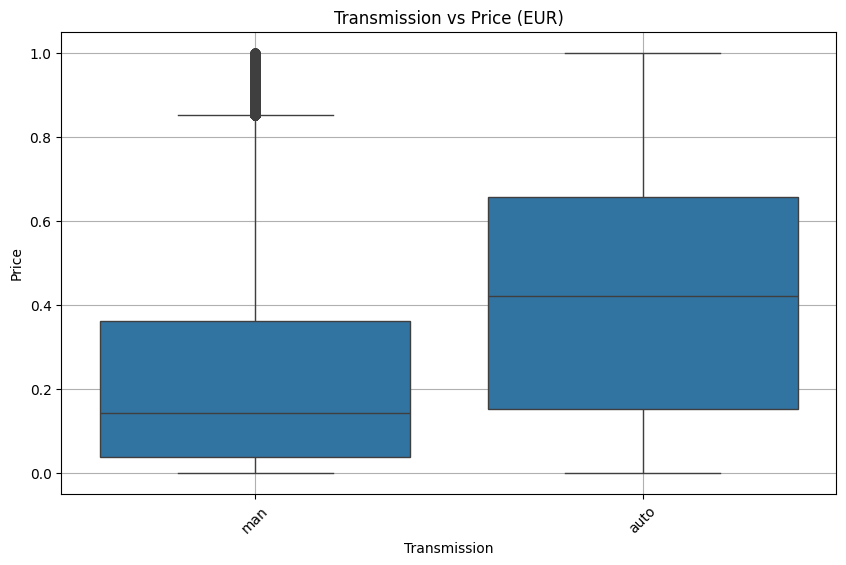

In [ ]:
# EDA-3

plt.figure(figsize=(10, 6))
sns.boxplot(x='transmission', y='car_price', data=df_1_noutliers)
plt.title('Transmission vs Price (EUR)')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)  # Add gridlines for better readability
plt.show()

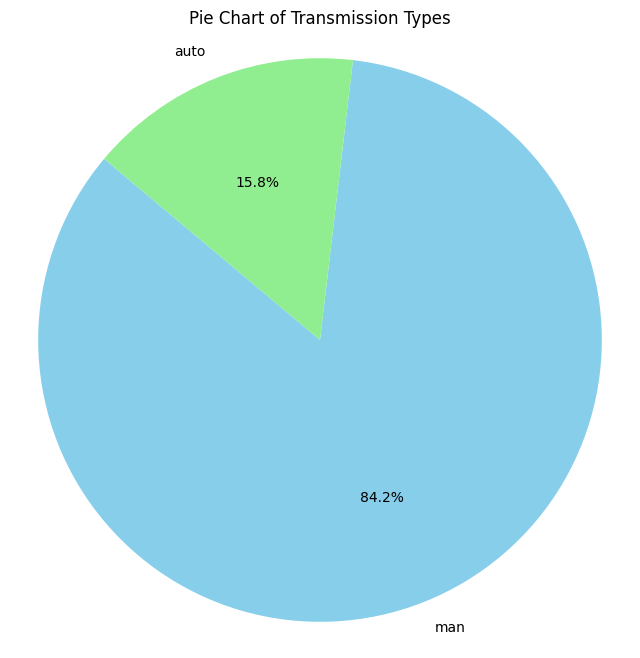

In [ ]:
# EDA-4

transmission_counts = df_1_noutliers['transmission'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(transmission_counts, labels=transmission_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.title('Pie Chart of Transmission Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

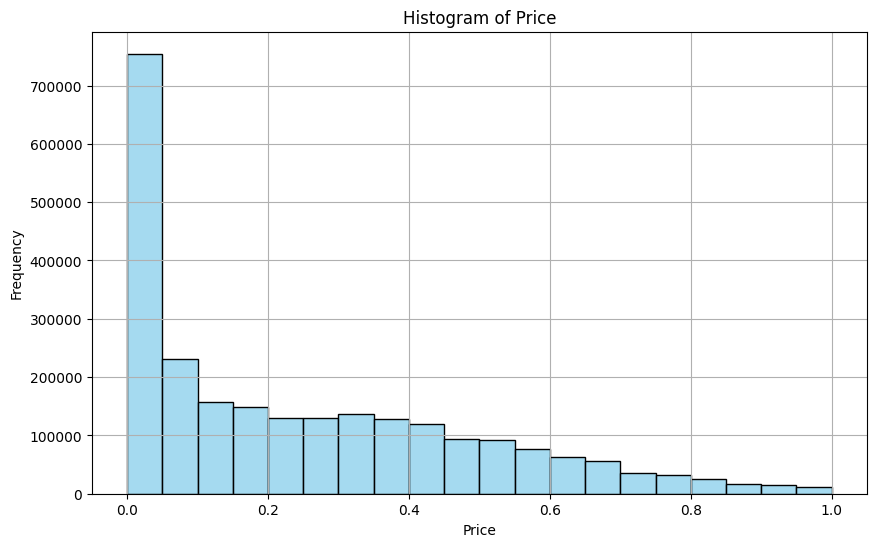

In [ ]:
# EDA-5

plt.figure(figsize=(10, 6))
sns.histplot(df_1_noutliers['car_price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)  # Add gridlines for better readability
plt.show()

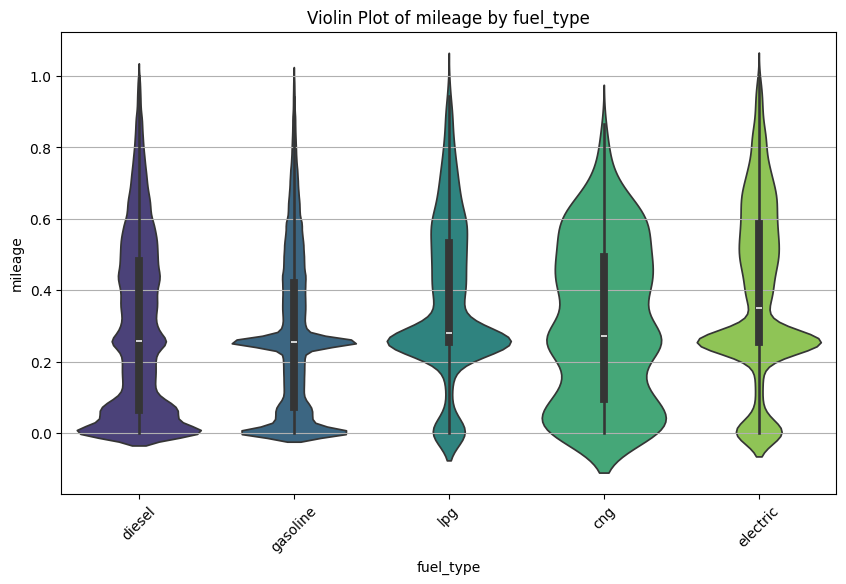

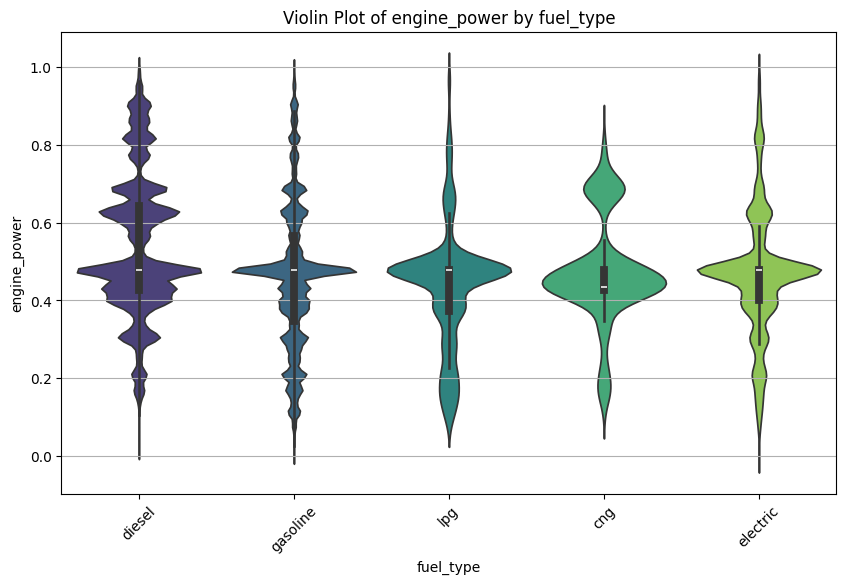

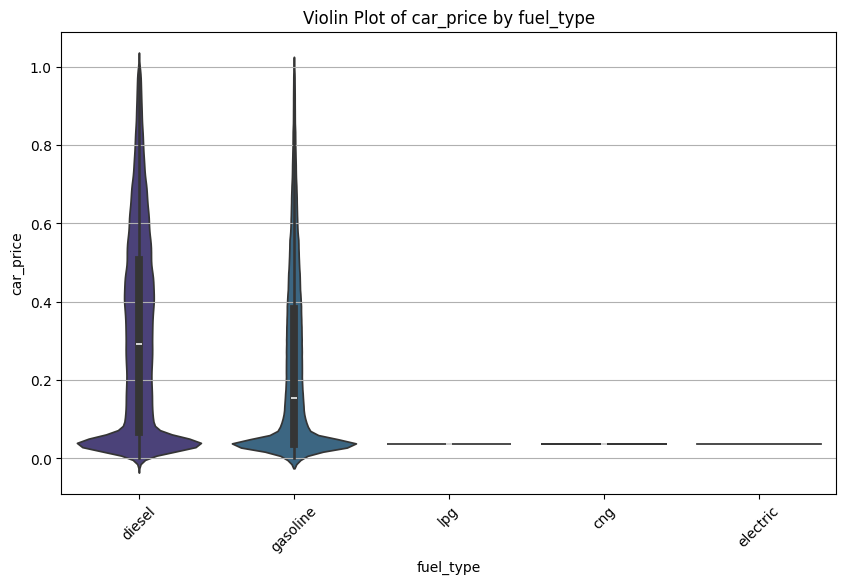

In [ ]:
# EDA-6

categorical_variable = 'fuel_type'
numeric_columns = ['mileage', 'engine_power', 'car_price']

# Create violin plots for each numeric column across different categories of the categorical variable
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=categorical_variable, y=column, data=df_1_noutliers, palette='viridis')
    plt.title(f'Violin Plot of {column} by {categorical_variable}')
    plt.xlabel(categorical_variable)
    plt.ylabel(column)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid(axis='y')  # Add gridlines for better readability
    plt.show()

In [ ]:
# EDA-7

maker_model_counts = df_1_noutliers.groupby(['maker', 'model']).size().reset_index(name='count').sort_values(by='count', ascending=False)
maker_model_counts

,maker,model,count
926,skoda,octavia,485107
665,mercedes-benz,octavia,122259
150,bmw,octavia,119349
918,skoda,fabia,85138
1030,volkswagen,golf,75900
...,...,...,...
142,bmw,golf,1
962,suzuki,felicia,1
141,bmw,focus,1
284,dodge,srt-4,1


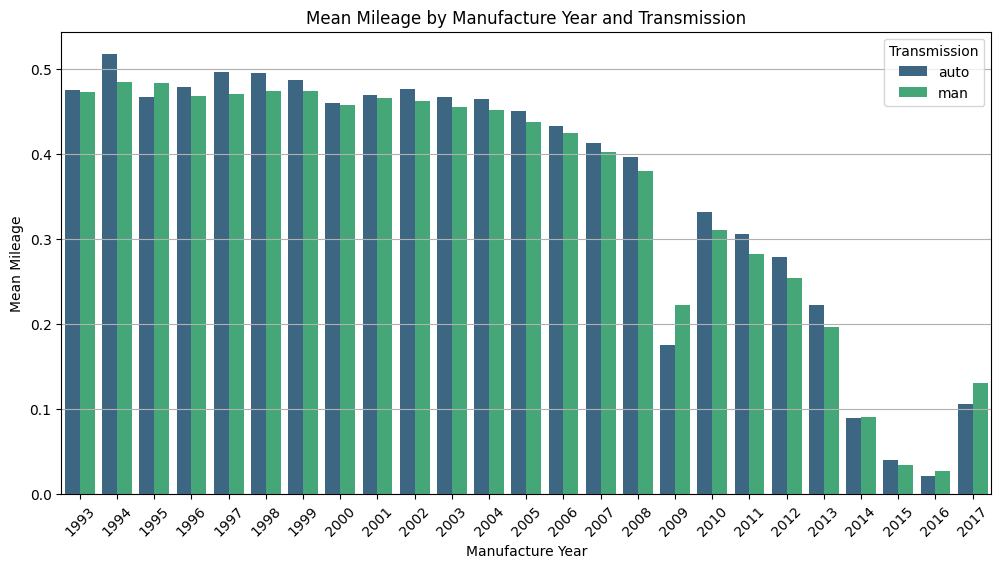

In [ ]:
#EDA-8

year_transmission_mileage_mean = df_1_noutliers.groupby(['manufacture_year', 'transmission'])['mileage'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=year_transmission_mileage_mean, x='manufacture_year', y='mileage', hue='transmission', palette='viridis')
plt.title('Mean Mileage by Manufacture Year and Transmission')
plt.xlabel('Manufacture Year')
plt.ylabel('Mean Mileage')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Transmission')
plt.grid(axis='y')  # Add gridlines for better readability
plt.show()

#Modelling

In [7]:
def data_split(df_model):

  X = df_model.drop(['car_price'], axis=1)
  y = df_model['car_price']

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return X,y,X_train, X_test, y_train, y_test

In [8]:
def model_metrics(y_test, y_pred):

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  return mse,r2

##Linear Regression

In [9]:
X,y,X_train, X_test, y_train, y_test = data_split(df_model)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_lr, r2_lr = model_metrics(y_test, y_pred)
print(f'Mean Squared Error: {mse_lr}')
print(f'R-squared: {r2_lr}')

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

Mean Squared Error: 0.02263024943569892
R-squared: 0.5904251201115034
                Feature   Coefficient
0               mileage -3.677839e-01
1      manufacture_year  1.345001e-02
2   engine_displacement -3.776064e-03
3          engine_power  3.250440e-01
4            door_count  1.563335e-03
5            seat_count -5.551115e-17
6     body_type_numeric  2.004888e-02
7  transmission_numeric  8.808298e-02
8     fuel_type_numeric -4.103695e-02


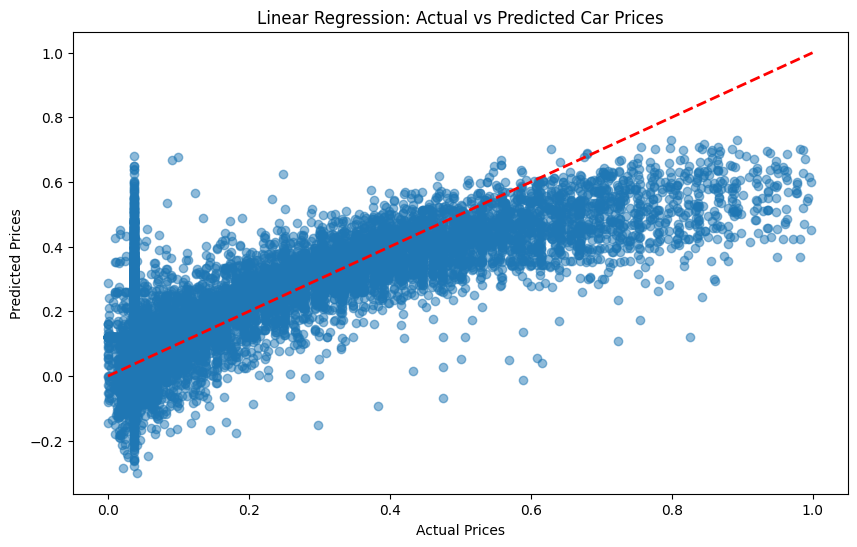

In [10]:
plt.figure(figsize=(10, 6))

# plt.scatter(y_test, y_pred, alpha=0.5)
plt.scatter(y_test[0:10000], y_pred[0:10000], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Linear Regression: Actual vs Predicted Car Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

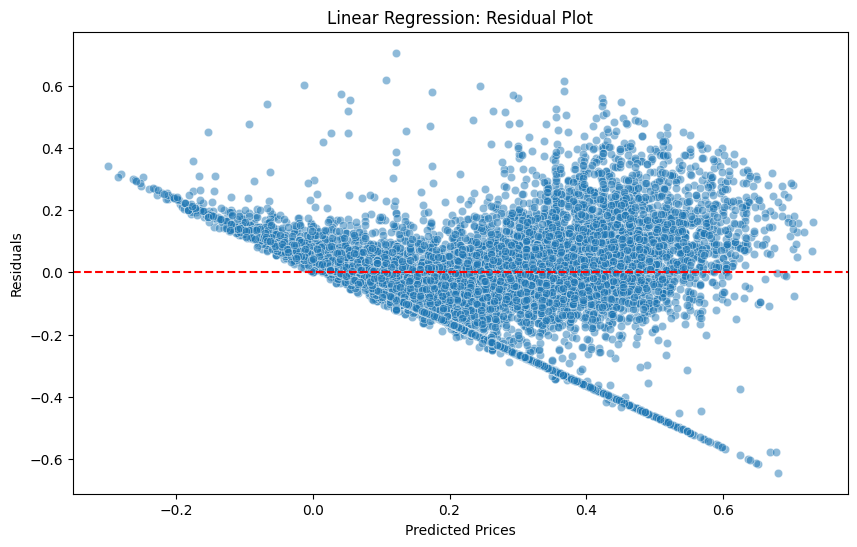

In [12]:
plt.figure(figsize=(10, 6))

residuals = (y_test[0:10000] - y_pred[0:10000])
sns.scatterplot(x=y_pred[0:10000], y=residuals, alpha=0.5)

plt.axhline(0, color='red', linestyle='--')
plt.title('Linear Regression: Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()

##Decision Tree Regression

In [14]:
X,y,X_train, X_test, y_train, y_test = data_split(df_model)
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

y_pred = dt_regressor.predict(X_test)

mse_dt, r2_dt = model_metrics(y_test, y_pred)
print(f'Mean Squared Error: {mse_dt}')
print(f'R-squared: {r2_dt}')

Mean Squared Error: 0.009590428032636449
R-squared: 0.826427082887121


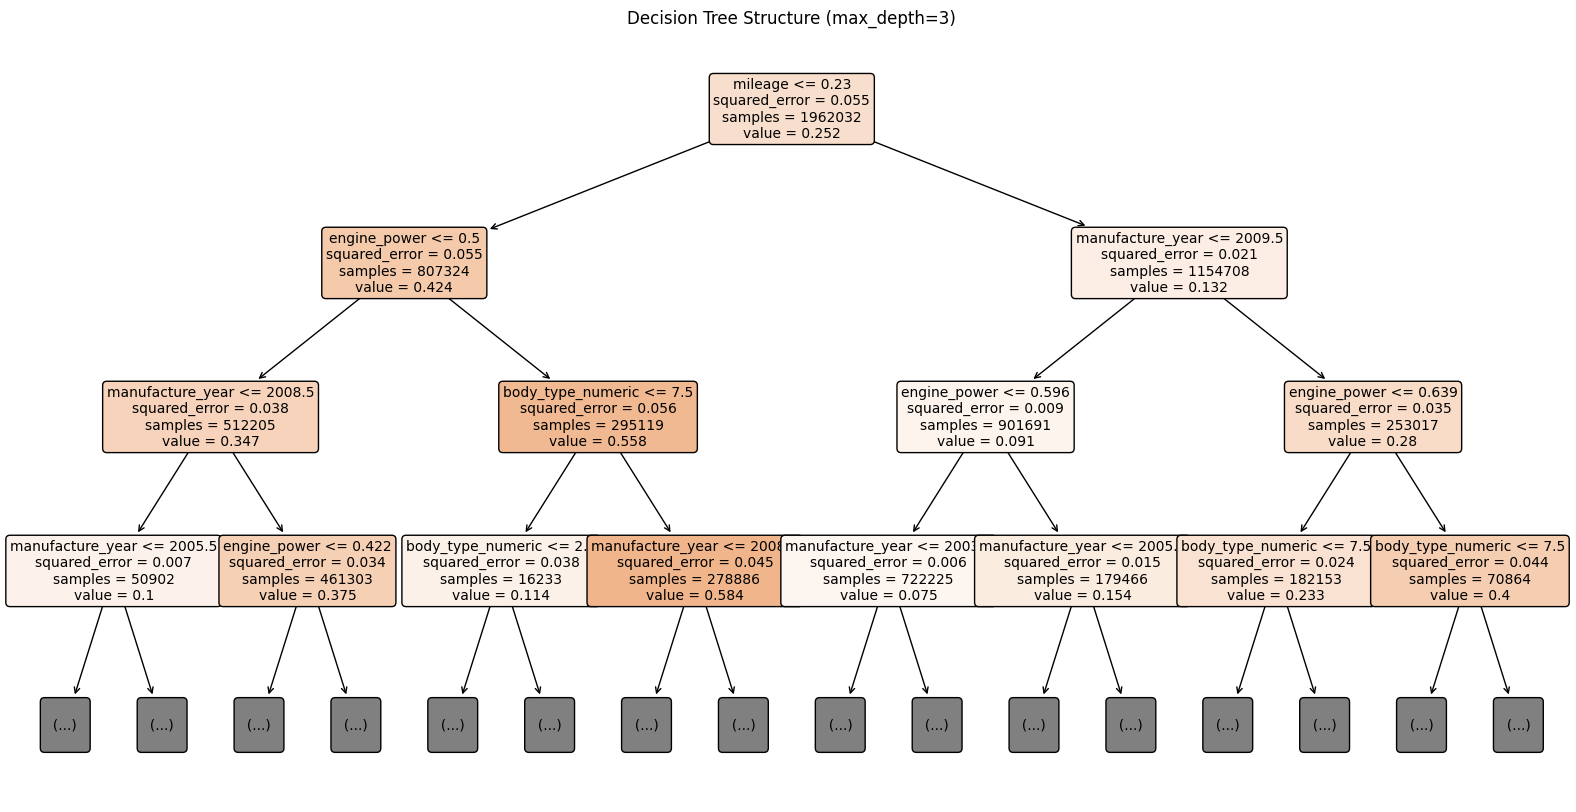

In [15]:
from sklearn.tree import plot_tree

# Limit the depth of the tree for visualization purposes
max_depth_to_display = 3

# Plot the decision tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True, fontsize=10, max_depth=max_depth_to_display)
plt.title(f'Decision Tree Structure (max_depth={max_depth_to_display})')
plt.show()

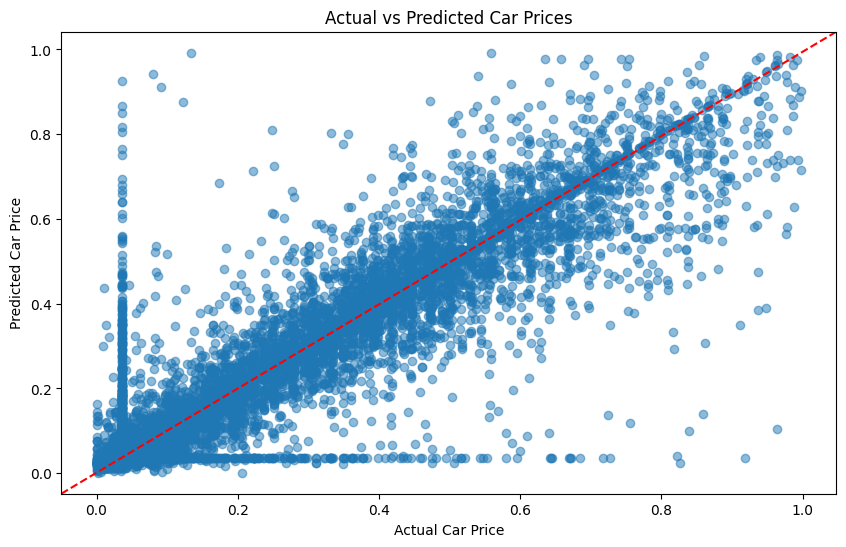

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[0:10000], y_pred[0:10000], alpha=0.5)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='dashed')
plt.xlabel('Actual Car Price')
plt.ylabel('Predicted Car Price')
plt.title('Actual vs Predicted Car Prices')
plt.show()

##Gradient Boost Regression

In [17]:
X,y,X_train, X_test, y_train, y_test = data_split(df_model)
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)

y_pred = gb_regressor.predict(X_test)

mse_gb, r2_gb = model_metrics(y_test, y_pred)
print(f'Mean Squared Error: {mse_gb}')
print(f'R-squared: {r2_gb}')

Mean Squared Error: 0.011480419621675583
R-squared: 0.7922209606669279


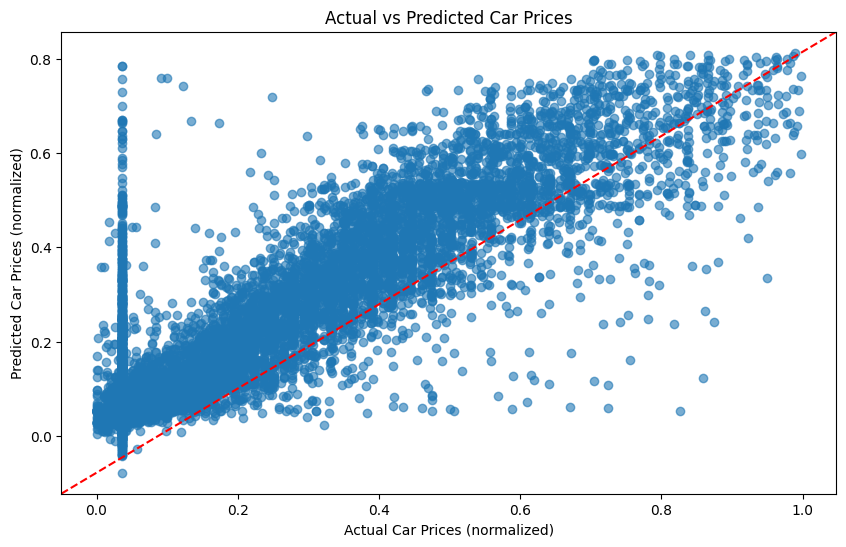

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[0:10000], y_pred[0:10000], alpha=0.6)
plt.plot([0, 1], [0, 1], '--', transform=plt.gca().transAxes, color='red')
plt.title('Actual vs Predicted Car Prices')
plt.xlabel('Actual Car Prices (normalized)')
plt.ylabel('Predicted Car Prices (normalized)')
plt.show()

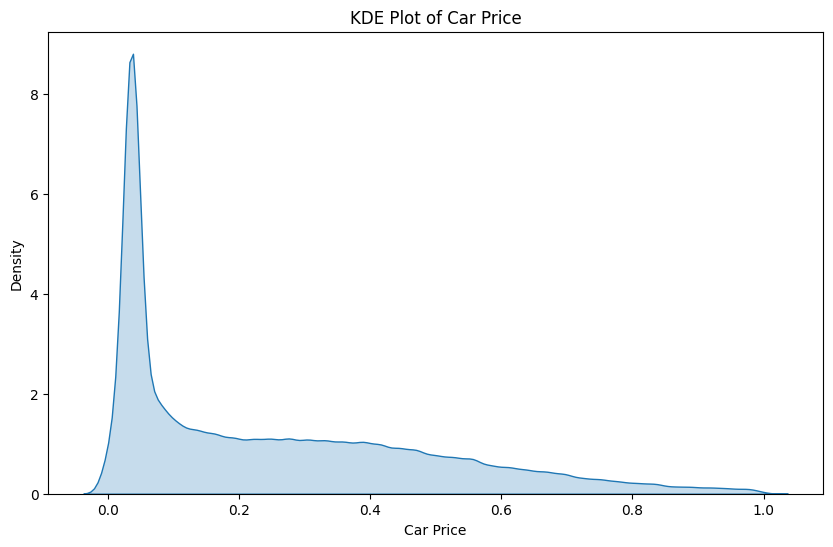

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_model['car_price'], shade=True)
plt.title('KDE Plot of Car Price')
plt.xlabel('Car Price')
plt.ylabel('Density')
plt.show()

##Random Forest Regression

In [9]:
X, y, X_train, X_test, y_train, y_test = data_split(df_model)
rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse_rf, r2_rf = model_metrics(y_test, y_pred)
print(f'Mean Squared Error: {mse_rf}')
print(f'R-squared: {r2_rf}')

Mean Squared Error: 0.007024851355317488
R-squared: 0.8728603209494477


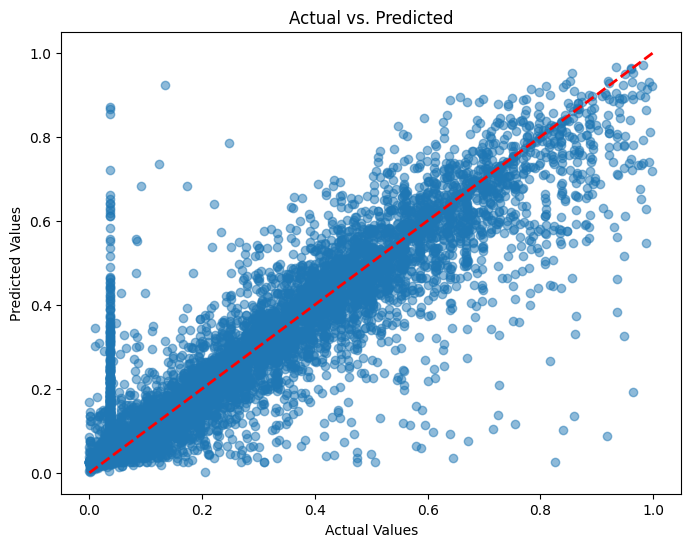

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test[0:10000], y_pred[0:10000], alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

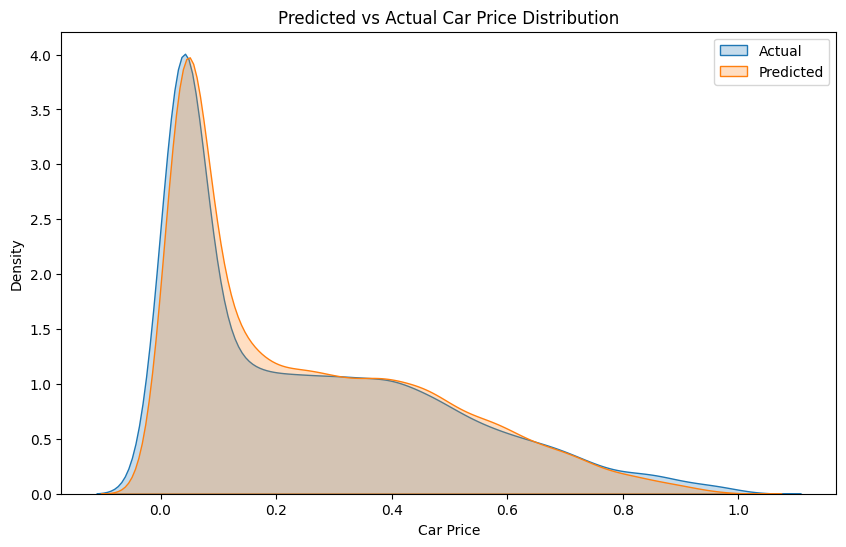

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test[0:10000], label='Actual', shade=True)
sns.kdeplot(y_pred[0:10000], label='Predicted', shade=True)
plt.xlabel('Car Price')
plt.title('Predicted vs Actual Car Price Distribution')
plt.legend()
plt.show()

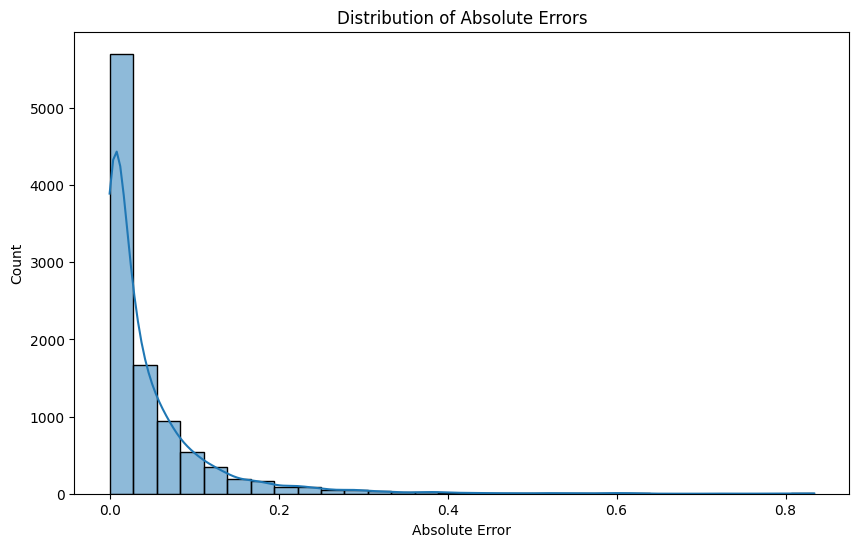

In [23]:
errors = abs(y_test[0:10000] - y_pred[0:10000])

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Absolute Error')
plt.title('Distribution of Absolute Errors')
plt.show()

##Lasso Regression

In [28]:
X,y,X_train, X_test, y_train, y_test = data_split(df_model)
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)

y_pred = lasso_reg.predict(X_test)

mse_lasso, r2_lasso = model_metrics(y_test, y_pred)
print(f"Mean Squared Error: {mse_lasso:.2f}")
print(f"R-squared: {r2_lasso:.4f}")

print(f"Lasso Regression Coefficients:\n{lasso_reg.coef_}")

Mean Squared Error: 0.03
R-squared: 0.3772
Lasso Regression Coefficients:
[-0.          0.02402494  0.          0.         -0.          0.
  0.          0.         -0.        ]


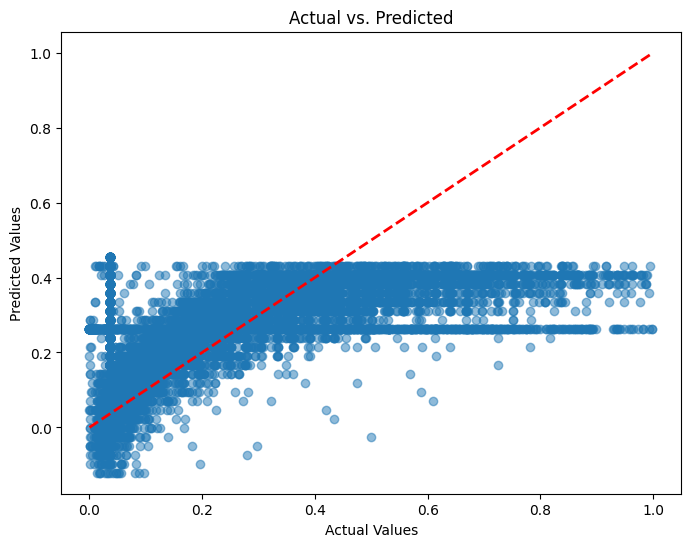

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test[0:10000], y_pred[0:10000], alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

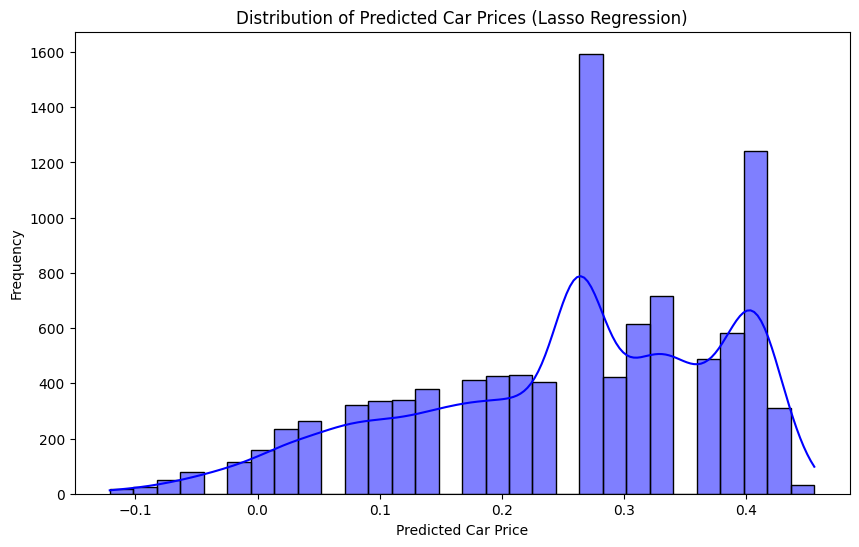

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred[0:10000], bins=30, kde=True, color='blue')
plt.xlabel('Predicted Car Price')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Car Prices (Lasso Regression)')
plt.show()

#Rough

##Support Vector Regressor

In [ ]:
# svr = SVR(kernel='rbf')
# svr.fit(X_train, y_train)

# y_pred = svr.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')

##KNN Model

In [ ]:
# knn = KNeighborsRegressor(n_neighbors=4)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')